<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/2_RedesDeUnaCapa/ejercicios/ejercicios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Ejercicios para la clase 2



En este notebook vamos a retomar el ejemplo de la red neuronal entrenada para clasificar FashionMNIST. Si bien ese ejemplo tiene todos los pasos necesarios para entrenar la red, varios de esos pasos sirven para entrenar cualquier otro modelo. Así que vamos a tratar de modularizarlo de manera que el código sea reutilizable.

Arranquemos importando los módulos necesarios.

In [194]:
import torch
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

Volvemos a definir la función que crea los Datasets y devuelve los DataLoaders para poder iterar sobre ellos.

In [195]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()] # ToTensor convierte a tensores y normaliza
    if resize: # Si se especifica un tamaño de imagen
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST( # Descarga el dataset de entrenamiento
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST( # Descarga el dataset de prueba
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, # Crea los dataloaders de entrenamiento y prueba con el tamaño de batch especificado y los datos descargados
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


#.DataLoader es una clase que permite cargar los datos de manera eficiente en batches de tamaño especificado

También definimos una función que devuelve la cantidad de aciertos del modelo a partir de un tensor de predicciones y otro de etiquetas.

In [196]:
#devuelve el numero de aciertos de la prediccion
def accuracy(y_hat, y): #y_hat es la prediccion y es el valor real
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: #si y_hat es un vector de vectores (matriz) y no un vector de numeros (vector) 
        y_hat = y_hat.argmax(axis=1) #devuelve el indice del valor mas grande de cada vector (el valor mas probable) 
    cmp = y_hat.type(y.dtype) == y #compara los valores de y_hat con los de y
    return float(cmp.type(y.dtype).sum()) #devuelve el numero de aciertos

Volvemos a definir el modelo con una capa de 10 neuronas para hacer la clasificación e inicializamos sus pesos aleatoriamente con una distribución gaussiana.

In [197]:
net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(784, 10)) # 28*28 = 784 pixels 
# net es mi modelo, el cual es una secuencia de capas.  Sequential es una clase que permite definir una secuencia de capas. cuyos parametros son 
# torch.nn.Flatten() que es una capa que aplana la imagen de 28x28 a un vector de 784 elementos
# torch.nn.Linear(784, 10) es una capa lineal que recibe 784 elementos y devuelve 10 elementos


def init_weights(m): # funcion que inicializa los pesos de la red neuronal con una distribucion normal de media 0 y desviacion estandar 0.01
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights); # aplica la funcion init_weights a la red neuronal net para inicializar los pesos

Definimos la entropía cruzada como función de perdida y el descenso de gradiente estocástico como algoritmo de optimización.

In [198]:
loss = torch.nn.CrossEntropyLoss(reduction='none') # declaro mi funcion de perdida con reduccion none para que no me haga el promedio de las perdidas
trainer = torch.optim.SGD(net.parameters(), lr=0.1) # declaro mi optimizador SGD con learning rate 0.1 y le paso los parametros de mi red

Y por último, definimos una función que lleva adelante el entrenamiento completo.

## Ejercicio 1

Implementar la función `train_epoch()` que lleva adelante el entrenamiento de una época.

In [199]:
def train_epoch(net, train_iter, loss, updater):
  '''
  Lleva adelante el entrenamiento de una sola época.

    Parámetros:
            net: la red neuronal que se va a entrenar
            train_iter: iterador de datos de entrenamiento
            loss: función de perdida a minimizar
            updater: algoritmo de optimización

    Salida:
            L: pérdida calculada
            Acc: accuracy de entrenamiento calculada
  '''
  # inserte su código aquí
  Acc = 0.0
  L = 0.0 #inicializacion de la perdida
  N = 0.0 #inicializacion del numero de datos
  for X, y in train_iter:
        l = loss(net(X) ,y) #calculo de la perdida
        updater.zero_grad() #reinicio de los gradientes
        l.sum().backward() #calculo de los gradientes con backpropagation
        updater.step() #actualizacion de los pesos
        with torch.no_grad(): 
            Acc += accuracy(net(X), y) #calculo del accuracy
            L += l.sum() #calculo de la perdida
            N += l.numel() #calculo del numero de datos
        return L/N, Acc/N #retorna la perdida y el accuracy

## Ejercicio 2

Implementar la función `test_accuracy()` que lleva adelante la evaluación de la performance de la red con los datos de prueba.

In [200]:
def test_accuracy(net, test_iter):
  '''
  Evalúa los resultados del entrenamiento de una sola época.

    Parámetros:
            net: la red neuronal que se va a evaluar
            test_iter: iterador de datos de prueba

    Salida:
            - TestAcc: accuracy de prueba calculada
  '''
  # inserte su código aquí
  TestAcc = 0.0
  TestN = 0.0
  with torch.no_grad():
      for X, y in test_iter:
                output = net(X)
                print(accuracy(output, y))
                TestAcc += accuracy(output, y)
                TestN += 1
  #print(TestN, TestAcc)
  return TestAcc/TestN
        

  


In [201]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
  '''
  Lleva adelante el entrenamiento completo llamando a funciones internas
  que modularizan el ciclo de entrenamiento.

    Parámetros:
            net: la red neuronal que se va a entrenar
            train_iter: iterador de datos de entrenamiento
            test_iter: iterador de datos de prueba
            loss: función de perdida a minimizar
            num_epoch: cantidad de épocas a entrenar
            updater: algoritmo de optimización

    Salida:
            metrics: una lista de tuplas (una para cada epoch)
              con las siguientes componentes
              - epoch: número de época
              - L: pérdida calculada
              - Acc: accuracy de entrenamiento calculada
              - TestAcc: accuracy de prueba calculada
  '''
  metrics =[]
  for epoch in range(num_epochs):
      L, Acc = train_epoch(net, train_iter, loss, updater)
      print("Epoch %d, Loss: %f, Train acc %f" % (epoch, L, Acc))
      TestAcc = test_accuracy(net, test_iter)
      metric = (epoch + 1, L, Acc, TestAcc)
#      print(metric)
      metrics.append(metric)
  return metrics

    


## Ejercicio 3

Utilizar las funciones anteriores para entrenar efectivamente a la red. Entrenarla por 10 epochs y con lotes de tamaño 256.

In [202]:
#inserte su código aquí
num_epochs = 10
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
lr = 0.01
# Entrenamiento de la red
metrics = train(net, train_iter, test_iter, loss, num_epochs, trainer)

# Imprime los resultados de cada época
for epoch, loss, acc, test_acc in metrics:
    print(f'Época [{epoch}/{num_epochs}], Pérdida: {loss:.4f}, Acc: {acc:.4f}, TestAcc: {test_acc:.4f}')

print('Entrenamiento completado.')

Epoch 0, Loss: 2.310339, Train acc 0.339844
75.0
71.0
76.0
79.0
81.0
69.0
94.0
76.0
87.0
74.0
72.0
76.0
78.0
83.0
84.0
69.0
77.0
79.0
75.0
77.0
77.0
81.0
88.0
74.0
86.0
75.0
72.0
67.0
78.0
78.0
84.0
75.0
76.0
74.0
96.0
82.0
81.0
69.0
72.0
6.0
Epoch 1, Loss: 58.521729, Train acc 0.125000
33.0
33.0
30.0
34.0
39.0
32.0
25.0
27.0
28.0
37.0
43.0
19.0
31.0
17.0
33.0
29.0
24.0
42.0
30.0
30.0
36.0
32.0
25.0
26.0
28.0
33.0
24.0
23.0
32.0
29.0
21.0
33.0
27.0
36.0
28.0
26.0
21.0
27.0
26.0
1.0
Epoch 2, Loss: 325.920654, Train acc 0.265625
85.0
65.0
58.0
58.0
55.0
61.0
55.0
71.0
56.0
59.0
56.0
76.0
59.0
67.0
52.0
64.0
75.0
62.0
60.0
52.0
51.0
61.0
62.0
63.0
68.0
64.0
52.0
63.0
60.0
51.0
50.0
61.0
60.0
64.0
54.0
57.0
58.0
69.0
59.0
5.0
Epoch 3, Loss: 632.459351, Train acc 0.175781
56.0
58.0
55.0
50.0
47.0
49.0
52.0
59.0
60.0
62.0
52.0
47.0
47.0
55.0
57.0
56.0
51.0
58.0
52.0
68.0
59.0
56.0
50.0
63.0
46.0
47.0
64.0
64.0
47.0
61.0
55.0
63.0
55.0
54.0
62.0
62.0
59.0
49.0
53.0
2.0
Epoch 4, Loss: 684.3610

## Ejercicio 4
Graficar la evolución de los valores de el accuracy de entrenamiento, el accuracy de prueba y la pérdida en función de las épocas.

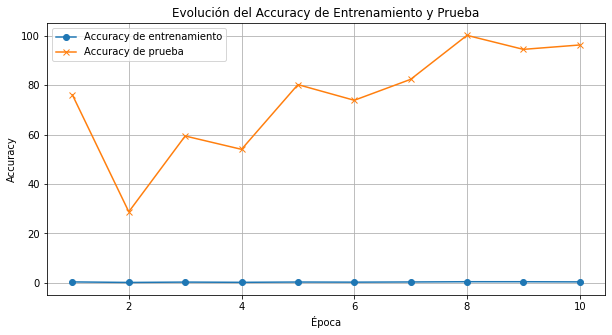

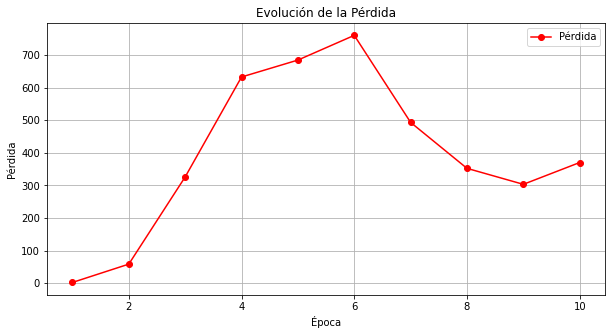

In [203]:
#inserte su código aquí
import matplotlib.pyplot as plt

# Supongamos que ya tienes los resultados en la lista `metrics`
# Cada elemento de la lista es una tupla (epoch, L, Acc, TestAcc)

epochs = [epoch for epoch, _, _, _ in metrics]
train_accuracy = [acc for _, _, acc, _ in metrics]
test_accuracy = [test_acc for _, _, _, test_acc in metrics]
loss = [loss for _, loss, _, _ in metrics]

# Graficar el accuracy de entrenamiento y de prueba
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Accuracy de entrenamiento', marker='o')
plt.plot(epochs, test_accuracy, label='Accuracy de prueba', marker='x')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Evolución del Accuracy de Entrenamiento y Prueba')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Pérdida', marker='o', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.grid(True)
plt.show()
